In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

In [2]:
nx, ny, nz = 270, 270, 405
x = np.arange(nx)[:, None, None]
y = np.arange(ny)[None, :, None]
z = np.arange(nz)[None, None, :]

R = nx / 2
x0 = R
y0 = ny - R
zj = nz - R
dx = 0.1 * R
dy = 10
bx = 0.3 * R
by = 0.3 * R
bz = 0.3 * R
buf = 1

rx = x - x0
ry = y - y0
r2 = rx * rx + ry * ry
dz = z - zj
Rb = R - buf

dome = np.where(z <= zj, r2 < (Rb * Rb), r2 + dz * dz < (Rb * Rb))

cx = x0 + dx
cy = y0 + dy + 25
cz = 2.0 * bz

box = ((np.abs(x - cx) <= bx) &
       (np.abs(y - cy) <= by) &
       (np.abs(z - cz) <= bz))

binary_media = np.where(z <= buf, 0,
                        np.where(dome & (~box), 1, 0)).astype(np.int64)

fluid = binary_media == 1
solid = binary_media == 0

# 26-connected offsets
off = [
    (i,j,k)
    for i in (-1,0,1)
    for j in (-1,0,1)
    for k in (-1,0,1)
    if not (i==0 and j==0 and k==0)
]

# ----- box adjacency -----
box_solid = (binary_media == 0) & box
adj_box = np.zeros_like(binary_media, bool)

for dx_, dy_, dz_ in off:
    xs = slice(max(0,-dx_), nx-max(0,dx_))
    ys = slice(max(0,-dy_), ny-max(0,dy_))
    zs = slice(max(0,-dz_), nz-max(0,dz_))
    xs2 = slice(max(0,dx_), nx-max(0,-dx_))
    ys2 = slice(max(0,dy_), ny-max(0,-dy_))
    zs2 = slice(max(0,dz_), nz-max(0,-dz_))

    adj_box[xs, ys, zs] |= box_solid[xs2, ys2, zs2] & (binary_media[xs, ys, zs] == 1)

binary_media[adj_box & (binary_media == 1)] = 3

# ----- wall adjacency -----
solid = (binary_media == 0)
adj_wall = np.zeros_like(binary_media, bool)

for dx_, dy_, dz_ in off:
    xs = slice(max(0,-dx_), nx-max(0,dx_))
    ys = slice(max(0,-dy_), ny-max(0,dy_))
    zs = slice(max(0,-dz_), nz-max(0,dz_))
    xs2 = slice(max(0,dx_), nx-max(0,-dx_))
    ys2 = slice(max(0,dy_), ny-max(0,-dy_))
    zs2 = slice(max(0,dz_), nz-max(0,-dz_))

    adj_wall[xs, ys, zs] |= solid[xs2, ys2, zs2] & (binary_media[xs, ys, zs] == 1)

binary_media[adj_wall & (binary_media == 1)] = 2

with h5py.File("binary_media.h5", "w") as f:
    f.create_dataset("binary_media", data=binary_media, dtype='i8')


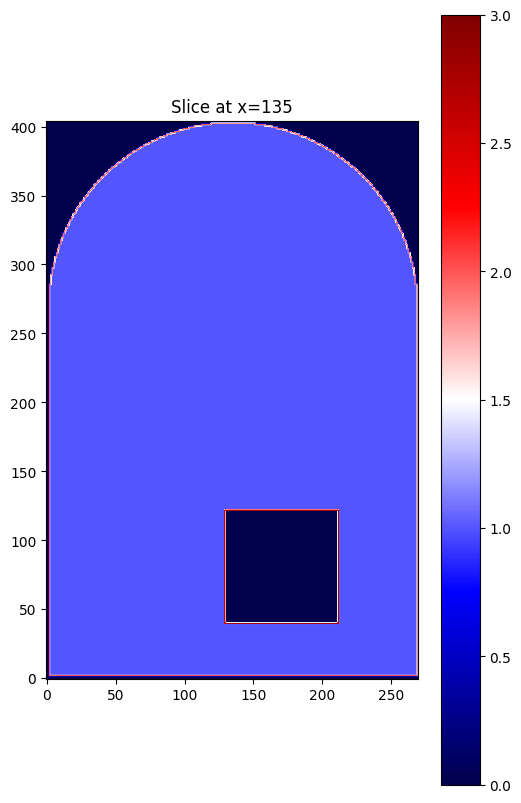

In [3]:
x_index = nx // 2
slice_img = binary_media[x_index, :, :]

plt.figure(figsize=(6,10))
plt.imshow(slice_img.T, origin='lower', cmap='seismic')
plt.colorbar()
plt.title(f"Slice at x={x_index}")
plt.show()


In [4]:
# Physical parameters (air specific)
Lx_phys = 2.0
Ly_phys = 2.0
Lz_phys = 3.0
gravity_phy = 9.81          # m/s^2
rho_phys   = 1.225      # density [kg/m^3]
nu_phys    = 1.5e-5     # kinematic viscosity [m^2/s]
alpha_phys = 2.1e-5     # thermal diffusivity [m^2/s]
# thermal expansion according to https://matmake.com/properties/thermal-expansion-of-common-materials.html
beta       = 3.4e-3     
g_phys     = 9.81       # gravity [m/s^2]
k_phys     = 0.026      # thermal conductivity [W/(m·K)] (air)
T_cold_phys = 293.15    # cold wall temperature [K] (e.g. 20°C)
deltaT_ref = 40.0       # temperature difference reference [K]

# LBM parameters
Nx = 270
Ny = 270
Nz = 405
gravity_lbm = 0.01          # lu/ts^2
tau_f = 0.55  # fluid
tau_g = 0.55  # thermal
cs2 = 1.0 / 3.0
nu_lbm    = cs2 * (tau_f - 0.5) # lu^2/ts
alpha_lbm = cs2 * (tau_g - 0.5) # lu^2/ts
T_lbm = 1.0

# Starting unit conversion
dx =  Lx_phys / Nx                  # m per lattice unit
dt = dx**2 * (nu_lbm / nu_phys)     # seconds per LBM timestep
du = dx / dt                        # m/s per lattice velocity unit
# temperate conversion needs lbm temperature field
T_phys = T_cold_phys + (T_lbm + 0.06 - 1.0) * deltaT_ref # K, 0.06 is an exmaple

print(f"dx = {dx:.3e} m/lu, dt = {dt:.3e} s/ts, du = {du:.3e} m/s per lu/ts, T_phys = {T_phys:.2f} K")

# Dimensionless numbers
# Prandtl number - ratio of momentum diffusivity to thermal diffusivity
Pr = nu_phys / alpha_phys
# Grashof number - ratio of buoyancy to viscous forces
Gr = g_phys * beta * (T_phys - T_cold_phys) * Lz_phys**3 / (nu_phys**2)
# Rayleigh number - characterizes turbulent convection
Ra = Gr * Pr 

print(f"Prandtl number: Pr = {Pr:.3e}, Grashof number: Gr = {Gr:.3e}, Rayleigh number: Ra = {Ra:.3e}")


dx = 7.407e-03 m/lu, dt = 6.097e-02 s/ts, du = 1.215e-01 m/s per lu/ts, T_phys = 295.55 K
Prandtl number: Pr = 7.143e-01, Grashof number: Gr = 9.606e+09, Rayleigh number: Ra = 6.861e+09
